In [1]:
"""
    Main script to launch the examples and benchmarks
"""
from argparse import ArgumentParser, ArgumentTypeError
import copy
import functools
from inspect import signature
import json
from pathlib import Path
import tempfile

from matplotlib import pyplot as plt
import numpy as np

from optimization import available_optimizers, launch_optimization
from quanting import available_ansatz, generate_ansatz_pool
from target import available_targets

TARGETS = list(available_targets.keys())
ANSATZS = list(available_ansatz.keys())
OPTIMIZ = list(available_optimizers.keys())
nicered = "#ff6150"


def check_qbits(var):
    nqbit = int(var)
    if nqbit < 1:
        raise ArgumentTypeError("Number of qubits must be positive")
    return nqbit


def valid_this(val_raw, options, name=""):
    """Ensures that the option val_raw is included in the available options"""
    # Make sure that everything is lowercase
    val = val_raw.lower()
    options = {i.lower(): k for i, k in options.items()}
    if val not in options:
        ava = list(options.keys())
        raise ArgumentTypeError(f"{name} {val_raw} not allowed, allowed options are {ava}")
    return options[val]


def valid_target(val_raw):
    return valid_this(val_raw, available_targets, "Target")


def valid_ansatz(val_raw, pdf_alpha=None, nderivatives=None):
    """Ensures that the selected ansatz exists
    Note that this does not check whether the number of dimensions/qbits/etc is acceptable
    acyclic graphs are beyond of the scope of this project...
    """
    ansatz_class = valid_this(val_raw, available_ansatz, "Ansatz")

    if pdf_alpha is not None:
        if "alpha" not in signature(ansatz_class).parameters.keys():
            raise ArgumentTypeError(f"pdf_alpha is not allowed for the ansatz {val_raw}")
        ansatz_class = functools.partial(ansatz_class, alpha=pdf_alpha)

    return ansatz_class


def valid_optimizer(val_raw):
    return valid_this(val_raw, available_optimizers, "Optimizer")


def ratio(pred, target, eps=1e-3):
    tts = np.where(np.abs(target) > eps, target, np.sign(target) * eps)
    ccs = np.where(np.abs(pred) > eps, pred, np.sign(pred) * eps)
    return np.abs(tts / ccs)


def plot_uquark(predictor, target, xmin, xmax, output_folder, npoints=50):
    """Plot botht he predictor and the target"""
    xmin = np.array(xmin)
    xmax = np.array(xmax)

    for d in range(target.ndim):
        xaxis_scale = "log"  # target.dimension_scale(d)
        # Create a linear space in the dimension we are plotting
        xlin = np.linspace(xmin[d], xmax[d], npoints)

        if xaxis_scale == "log":
            # change to log
            xlin = np.logspace(np.log10(xmin[d]), np.log10(xmax[d]), npoints)

        for i in range(target.ndim):
            # For every extra dimension do an extra plot so that we have more random points
            # in the other dimensions

            # Select a random point in the other dimensions
            xran_origin = np.random.rand(target.ndim) * (xmax - xmin) + xmin

            ytrue = []
            all_xs = []

            for xx in xlin:
                xran = copy.deepcopy(xran_origin)
                xran[d] = xx
                ytrue.append(target(xran))
                all_xs.append(xran)

            ypred = predictor.vectorized_forward_pass(all_xs)

            if target.ndim == 2:
                # when there is only 2 dimensions only one variable is fixed
                # and so we can actually write the numerical value
                other_d = (d + 1) % 2
                fixed_name = target.dimension_name(other_d)
                tag = f"{fixed_name}={xran[other_d]:.2}"
            else:
                tag = f"n{i}"

            rr = ratio(ypred, ytrue)

            # plotting
            fig, (ax1, ax2) = plt.subplots(
                2, 1, sharex=True, figsize=(4.5, 4.5 * 6 / 8), gridspec_kw={"height_ratios": [5, 2]}
            )

            ax1.plot(
                xlin,
                ypred,
                label=f"Approximation {tag}",
                linewidth=2.5,
                alpha=0.9,
                ls="-",
                color="#ff6150",
            )
            ax1.plot(
                xlin,
                np.stack(ytrue),
                label=f"Target $u$-quark {tag}",
                linewidth=1.5,
                alpha=0.7,
                ls="--",
                color="black",
            )
            ax1.grid(False)
            ax1.set_xscale(xaxis_scale)
            ax1.set_ylabel(r"$u\,f(x)$")
            ax1.set_title(rf"$u$-quark PDF fit", fontsize=12)
            fig.legend(bbox_to_anchor=(0.55, 0.52), framealpha=1)

            ax2.plot(xlin, rr, color=nicered, lw=2.5, alpha=0.9)
            ax2.hlines(1, 1e-4, 1, color="black", ls="--", lw=1.5, alpha=0.7)
            ax2.grid(False)
            ax2.set_xscale(xaxis_scale)
            ax2.set_xlabel(r"x")
            ax2.set_ylabel("Ratio")
            ax2.set_ylim(0.97, 1.03)

            plt.rcParams["xtick.bottom"] = True
            plt.rcParams["ytick.left"] = True

            fig.subplots_adjust(wspace=0, hspace=0)

        plt.savefig(output_folder / f"uquark1d.pdf", bbox_inches="tight")
        plt.close()


def plot_integrand(predictor, target, xmin, xmax, output_folder, npoints=50):
    if "quark" in str(target):
        return plot_uquark(predictor, target, xmin, xmax, output_folder, npoints=50)

    xmin = np.array(xmin)
    xmax = np.array(xmax)

    for d in range(target.ndim):
        xaxis_name = target.dimension_name(d)
        xaxis_scale = target.dimension_scale(d)
        # Create a linear space in the dimension we are plotting
        xlin = np.linspace(xmin[d], xmax[d], npoints)

        if xaxis_scale == "log":
            # change to log
            xlin = np.logspace(np.log10(xmin[d]), np.log10(xmax[d]), npoints)

        for i in range(target.ndim):
            # For every extra dimension do an extra plot so that we have more random points
            # in the other dimensions

            # Select a random point in the other dimensions
            xran_origin = np.random.rand(target.ndim) * (xmax - xmin) + xmin

            ytrue = []
            all_xs = []

            for xx in xlin:
                xran = copy.deepcopy(xran_origin)
                xran[d] = xx
                ytrue.append(target(xran))
                all_xs.append(xran)

            ypred = predictor.vectorized_forward_pass(all_xs)

            if target.ndim == 2:
                # when there is only 2 dimensions only one variable is fixed
                # and so we can actually write the numerical value
                other_d = (d + 1) % 2
                fixed_name = target.dimension_name(other_d)
                tag = f"{fixed_name}={xran[other_d]:.2}"
            else:
                tag = f"n={i}"

            color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

            plt.plot(
                xlin,
                ypred,
                label=f"Approximation {tag}",
                linewidth=2.5,
                alpha=0.6,
                ls="-",
                color=color,
            )
            plt.plot(
                xlin,
                np.stack(ytrue),
                label=f"Target {tag}",
                linewidth=1.5,
                alpha=0.8,
                ls="--",
                color=color,
            )

        plt.grid(True)
        plt.xscale(xaxis_scale)
        # plt.title(f"Integrand fit, dependence on {xaxis_name}")
        plt.xlabel(rf"${xaxis_name}$")
        plt.xlabel(r"x")
        plt.ylabel(r"$u\,f(x)$")
        plt.savefig(output_folder / f"output_plot_d{d+1}.pdf")
        plt.close()


def _generate_limits(xmin, xmax, dimensions=1):
    """Generate the lists of limits to evaluate the primitive at

    For the dimensions that are not integrated the upper limits
    will be used as value with which the circuit will be called

    Parameters
    ---------
        xmin: list of inferior limits (one per dimension)
        xmax: list of superior limits
        dimensions: int
            dimensions over which the integral is taken

    Returns
    -------
        limits: list of 1d arrays with one value per dimension
        signs: list of same size with + or -
    """
    limits = [np.array([])]
    signs = [1.0]
    for i, (xm, xp) in enumerate(zip(xmin, xmax)):
        next_l = []
        next_s = []
        for curr_l, curr_s in zip(limits, signs):
            if i < dimensions:
                next_l.append(np.concatenate([curr_l, [xm]]))
                next_s.append(-curr_s)

            next_l.append(np.concatenate([curr_l, [xp]]))
            next_s.append(curr_s)
        limits = next_l
        signs = next_s

    return limits, signs


def _generate_integration_x(xmin, xmax, padding=False, npoints=int(5e2)):
    """Generate a set of random poitns within the integration limits"""
    xmin = np.array(xmin)
    xmax = np.array(xmax)
    if padding:
        xdelta = xmax - xmin
        xmin -= 0.1 * xdelta
        xmax += 0.1 * xdelta
    return np.random.rand(npoints, len(xmin)) * (xmax - xmin) + xmin


def error_over_runs(results, errors):  # not being used at the moment
    """Calculate error of the measurements provided with their errors"""
    N = len(results)
    var = np.var(results)
    return var**2 / N + (1 / N**2) * np.sum(errors**2)

[Qibo 0.2.2|INFO|2024-03-25 11:23:27]: Using numpy backend on /CPU:0
2024-03-25 11:23:27.844070: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 11:23:28.697898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kban/MG5_aMC/ExRootAnalysis:/SATA_SSD/kban/HEPTools/MG5_aMC_v3_4_1/HEPTools/lhapdf6_py3/lib:/SATA_SSD/kban/HEPTools/root../root_build/lib:/SATA_SSD/kban/HEPTools/root/include:/SATA_SSD/kban/HEPTools/root/lib:/SATA_SSD/kban/HEPTools/MG5_aMC_v3_4_1/HEPTools/fastjet/lib:/SATA_SSD/kban/HEPTools/MG5_aMC_v3_4_1/HEPTools/hepmc/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/:/home/kban/MG5_aMC/ExRootAnalysis:/SATA_SSD/kban/HEPTools/MG5_aMC_v3_4_1/HEPTools/lhapdf6_py3/lib:/SA

In [2]:
from target import *

In [3]:
target_function = "uquark2d"  # 대상 함수
a_target = valid_target(target_function)


In [4]:
target_fun = a_target(ndim=2)

[INFO] (pdfflow.pflow) Loading member 0 from nnpdf40


Preparing xu(x) with d=2


In [5]:
xarr = np.array(target_fun.xgrid).reshape(-1, target_fun.ndim)

In [6]:
ydata = np.array([target_fun(i) for i in xarr])

In [7]:
from pdfflow import mkPDF

In [8]:
from pathlib import Path
import os

# For Jupyter notebooks
notebook_path = %pwd
dirname = Path(notebook_path).parent

_pdf = mkPDF("nnpdf40/0", dirname=notebook_path)

[INFO] (pdfflow.pflow) Loading member 0 from nnpdf40


In [70]:
_min_x = 1e-3
_min_q = 25.0
_max_x = 0.7
_max_q = 125.0

In [71]:
q = _min_q + xarr[:,1] * (_max_q - _min_q)

In [72]:
q_167 = np.array([1.67]*12000)

(0.0, 0.8)

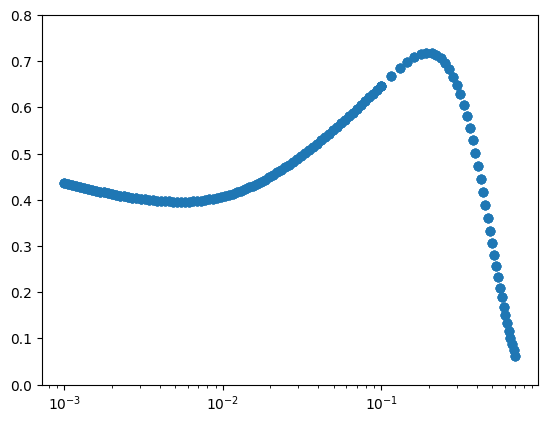

In [73]:
## 논문 Figure 4 when Q=1.67 with x = (0.001~0.7)
plt.scatter(xarr[:500,0], _pdf.py_xfxQ2(2, xarr[:,0], q_167**2).numpy()[:500])
plt.xscale('log')
plt.ylim(0,0.8)

(0.1, 100)

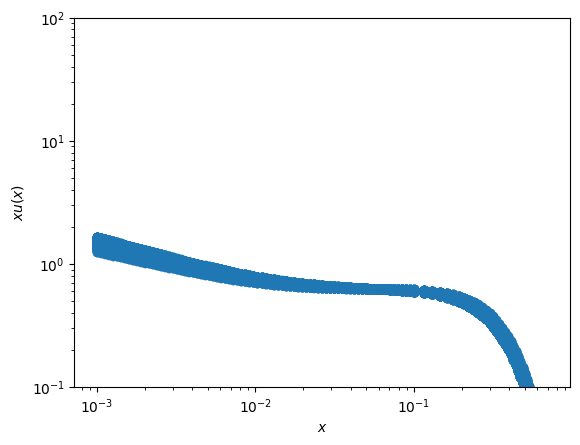

In [74]:
## plot with various Q**2 values
plt.scatter(xarr[:,0], _pdf.py_xfxQ2(2, xarr[:,0], q**2).numpy())
plt.xlabel("$x$")
plt.ylabel("$xu(x)$")
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1,100)

In [86]:
def integral(xmin, xmax, scaled_q=1.0, verbose=True, exact=False):
    q = scaled_q * (_max_q - _min_q) + _min_q
    if verbose:
        print(f"Computing the integral for {q=}")

#     if exact:
#         # This is slower but exact, otherwise just approximate the integration
#         # fun = lambda x: self([x, scaled_q])
#         fun = lambda x: _pdf.py_xfxQ2(2, [x], [scaled_q**2]).numpy()
#         return nquad(fun, [(xmin, xmax)])

    npoints = 2000

    # Take only the x
    if not isinstance(xmin, (float, int)):
        xmin = xmin[0]
        xmax = xmax[0]

    # First integrate at small x
    xgrids = []
    if xmin < 0.1:
        xgrids.append(np.logspace(np.log(xmin), -1, npoints // 2))
    if xmax > 0.1:
        xgrids.append(np.linspace(0.1, xmax, npoints // 2))
    xgrid = np.concatenate(xgrids)

    # Get weights
    sp = np.diff(xgrid, append=xgrid[-1], prepend=xgrid[0])
    weights = (sp[1:] + sp[:-1]) / 2.0

    q2grid = np.ones_like(xgrid) * q**2

    pdf_vals = _pdf.py_xfxQ2(2, xgrid, q2grid)

    return np.sum(pdf_vals * weights), 0.0

In [87]:
n_points = 20
qscaled_points = np.linspace(0, 1, n_points)
q2points = (qscaled_points * (_max_q - _min_q) + _min_q) ** 2
integral_results = []

for qscaled, q2 in zip(qscaled_points, q2points):
    res, error = integral(xmin=10**-4, xmax=0.7, scaled_q=qscaled, verbose=False, exact=False)
    integral_results.append(res)

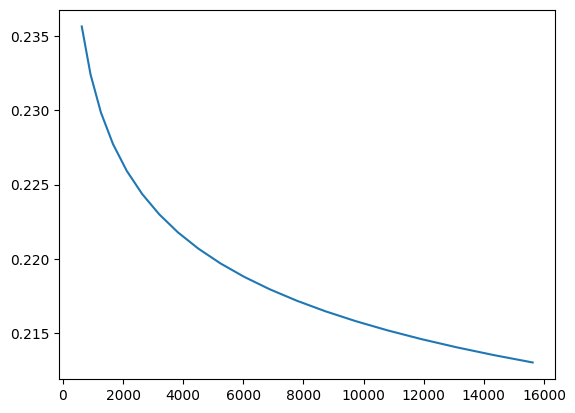

In [85]:
plt.plot(q2points, integral_results)
ax.set_xlabel("$x$")
ax.set_ylabel("$xu(x)$")